In [93]:
import pandas as pd
from pandas.io.json import loads, json_normalize

# challenge specifies to load fullVisitorId as a string to guarantee uniqueness
id_to_str = {'fullVisitorId': str}

train = pd.read_csv('./all/train.csv', nrows=100000, dtype=id_to_str)
test  = pd.read_csv('./all/test.csv', nrows=100000, dtype=id_to_str)

In [94]:
def parse_json_cols(df):
    for col in ['device', 'geoNetwork', 'totals', 'trafficSource']:
        # load the json and separate
        df_json = json_normalize(df[col].apply(loads), sep='/')
        df_json.columns = [(col + '/' + c) for c in df_json.columns]
        df.drop(columns=col, inplace=True)
        df = pd.concat([df, df_json], axis=1)
    return df

#
train = parse_json_cols(train)
test  = parse_json_cols(test)

---
# Examine data

### Dates are not parsed and visitStartTime is in POSIX time
    * visitStartTime makes Date redundant (more information encoded)
    * need to get continuous time data (hour, minute)

In [95]:
from datetime import datetime

def parse_dates(df):
    df['visitStartTime'] = df['visitStartTime'].apply(lambda time: datetime.fromtimestamp(time))
    df['year']  = df['visitStartTime'].dt.year
    df['month'] = df['visitStartTime'].dt.month
    df['day']   = df['visitStartTime'].dt.day
    df['hour']  = df['visitStartTime'].dt.hour + (df['visitStartTime'].dt.minute/60)
    df.drop(columns=['date', 'visitStartTime'], inplace=True)

    return df

#
train = parse_dates(train)
test  = parse_dates(test)

### Several columns have NaN values
* Every value in totals should have a lower bound of 0.
* Will fill remainder with most frequent value

In [96]:
nan_series = train.isna().any()
nan_true   = nan_series[nan_series == True]
nan_true

totals/bounces                                  True
totals/newVisits                                True
totals/pageviews                                True
totals/transactionRevenue                       True
trafficSource/adContent                         True
trafficSource/adwordsClickInfo/adNetworkType    True
trafficSource/adwordsClickInfo/gclId            True
trafficSource/adwordsClickInfo/isVideoAd        True
trafficSource/adwordsClickInfo/page             True
trafficSource/adwordsClickInfo/slot             True
trafficSource/campaignCode                      True
trafficSource/isTrueDirect                      True
trafficSource/keyword                           True
trafficSource/referralPath                      True
dtype: bool

In [97]:
def clean_nans(df):
    totals_cols = list(filter(lambda c : c.startswith('totals'), df.columns))
    for i in totals_cols:
        df[i] = df[i].astype(float)
        df[i].fillna(0, inplace=True)
   
    nan_series = df.isna().any()
    nan_true   = nan_series[nan_series == True]
    remaining_nan_cols = list(set(nan_true.index) - set(totals_cols))
    
    for i in remaining_nan_cols:
        # fill with most frequent value
        df[i].fillna(df[i].value_counts().index[0], inplace=True)
        
    return df

#
train = clean_nans(train)
test  = clean_nans(test)

### Several columns have 1 unique value
    * Provide no information, so will drop

In [98]:
for col in train:
    if len(train[col].unique()) == 1:
        print(col)

socialEngagementType
device/browserSize
device/browserVersion
device/flashVersion
device/language
device/mobileDeviceBranding
device/mobileDeviceInfo
device/mobileDeviceMarketingName
device/mobileDeviceModel
device/mobileInputSelector
device/operatingSystemVersion
device/screenColors
device/screenResolution
geoNetwork/cityId
geoNetwork/latitude
geoNetwork/longitude
geoNetwork/networkLocation
totals/visits
trafficSource/adwordsClickInfo/criteriaParameters
trafficSource/adwordsClickInfo/isVideoAd
trafficSource/campaignCode
trafficSource/isTrueDirect


In [99]:
def drop_single_val_cols(df):
    for col in df:
        if len(df[col].unique()) == 1:
            df.drop(columns=[col], inplace=True)
    return df

#
train = drop_single_val_cols(train)
test  = drop_single_val_cols(test)

### A lot of data is categorical
* Thinks like referal links, locations, and keywords are categorical and need to be represented as such
* Will use sklearn's LabelEncoder
    * fit on all possible values for a column, then transform

In [100]:
list(train.select_dtypes(include='object').columns)

['channelGrouping',
 'fullVisitorId',
 'sessionId',
 'device/browser',
 'device/deviceCategory',
 'device/operatingSystem',
 'geoNetwork/city',
 'geoNetwork/continent',
 'geoNetwork/country',
 'geoNetwork/metro',
 'geoNetwork/networkDomain',
 'geoNetwork/region',
 'geoNetwork/subContinent',
 'trafficSource/adContent',
 'trafficSource/adwordsClickInfo/adNetworkType',
 'trafficSource/adwordsClickInfo/gclId',
 'trafficSource/adwordsClickInfo/page',
 'trafficSource/adwordsClickInfo/slot',
 'trafficSource/campaign',
 'trafficSource/keyword',
 'trafficSource/medium',
 'trafficSource/referralPath',
 'trafficSource/source']

In [101]:
from sklearn.preprocessing import LabelEncoder

for i in train.select_dtypes(include='object').columns:
    # get list of all possible categories for each column
    all_categories = list(set(list(train[i].unique()))\
                     | set(list(test[i].unique())))

    encoder = LabelEncoder()
    # fit on column
    encoder.fit(all_categories)
    train[i] = encoder.transform(train[i])
    test[i]  = encoder.transform(test[i])

### Predict natural log of revenue
* Target specified as ln(total transaction revenue + 1)
    * Need to convert transactionRevenue column to accomodate
* Evaluate with RMSE

In [106]:
from numpy import log1p

# to make the line more readable
i = 'totals/transactionRevenue'

train[i] = train[i].apply(lambda revenue: log1p(revenue))

# External Dataset: OECD Consumer Confidence Index

OECD - Total from Jan 2016 - Sep 2018

https://data.oecd.org/leadind/consumer-confidence-index-cci.htm#indicator-chart


* OECD (2018), Consumer confidence index (CCI) (indicator). doi: 10.1787/46434d78-en (Accessed on 11 October 2018)

In [136]:
def add_cci(df):
    cci = pd.read_csv('./all/oecd_total_cci.csv', index_col=0)
    cci_dict = cci.to_dict()['Value']
    df['year-month']  = df['year'].astype(str) + '-' + df['month'].astype(str)
    
    df['cci'] = df['year-month'].map(cci_dict)
    df['cci'].fillna(df['cci'].median(), inplace=True)
    
    df.drop(columns=['year-month'], inplace=True)
    return df

train = add_cci(train)
test  = add_cci(test)

---
# Visualize

In [165]:
train.corr()

,channelGrouping,fullVisitorId,sessionId,visitId,visitNumber,device/browser,device/deviceCategory,device/isMobile,device/operatingSystem,geoNetwork/city,...,trafficSource/campaign,trafficSource/keyword,trafficSource/medium,trafficSource/referralPath,trafficSource/source,year,month,day,hour,cci
channelGrouping,1.000000,0.002830,0.002832,-0.206452,-0.039646,0.108538,-0.219050,-0.238215,0.036194,-0.008405,...,-0.180634,-0.017834,0.820530,0.757227,0.932689,-0.218354,0.171051,0.011377,-0.034325,-0.056318
fullVisitorId,0.002830,1.000000,0.999999,-0.000948,-0.029605,0.000686,0.001566,0.001562,-0.001745,0.002595,...,0.003994,-0.001319,0.002339,0.000656,0.000875,-0.002378,0.002706,0.005867,0.003692,-0.002851
sessionId,0.002832,0.999999,1.000000,-0.000951,-0.029609,0.000688,0.001565,0.001562,-0.001741,0.002597,...,0.003995,-0.001324,0.002340,0.000659,0.000876,-0.002381,0.002708,0.005864,0.003685,-0.002846
visitId,-0.206452,-0.000948,-0.000951,1.000000,0.004475,-0.054519,0.139118,0.151480,-0.014525,0.039891,...,0.008574,0.077726,-0.090602,-0.307354,-0.249542,0.866732,-0.492447,-0.059958,0.030545,-0.001588
visitNumber,-0.039646,-0.029605,-0.029609,0.004475,1.000000,-0.042754,-0.038334,-0.040382,0.004439,0.003271,...,-0.006404,-0.009970,-0.035906,-0.059546,-0.047765,0.007682,-0.008925,-0.001345,0.019359,0.006528
device/browser,0.108538,0.000686,0.000688,-0.054519,-0.042754,1.000000,0.285575,0.272805,0.171948,0.031814,...,-0.028068,0.059031,0.063643,0.194703,0.138060,-0.075967,0.076180,0.017459,-0.018051,-0.029685
device/deviceCategory,-0.219050,0.001566,0.001565,0.139118,-0.038334,0.285575,1.000000,0.945925,-0.084144,0.070056,...,0.013255,0.080235,-0.160634,-0.200552,-0.227627,0.138374,-0.097899,-0.031323,0.047316,0.020440
device/isMobile,-0.238215,0.001562,0.001562,0.151480,-0.040382,0.272805,0.945925,1.000000,-0.134512,0.055277,...,0.009048,0.083309,-0.176099,-0.215726,-0.246458,0.150527,-0.106357,-0.034080,0.050163,0.020566
device/operatingSystem,0.036194,-0.001745,-0.001741,-0.014525,0.004439,0.171948,-0.084144,-0.134512,1.000000,0.094182,...,0.019343,-0.016630,0.067980,0.075554,0.037027,-0.006122,-0.004658,0.005815,-0.042350,-0.007013
geoNetwork/city,-0.008405,0.002595,0.002597,0.039891,0.003271,0.031814,0.070056,0.055277,0.094182,1.000000,...,0.010953,0.024226,0.037206,-0.012707,-0.008439,0.065111,-0.072737,-0.011986,0.043923,-0.013510


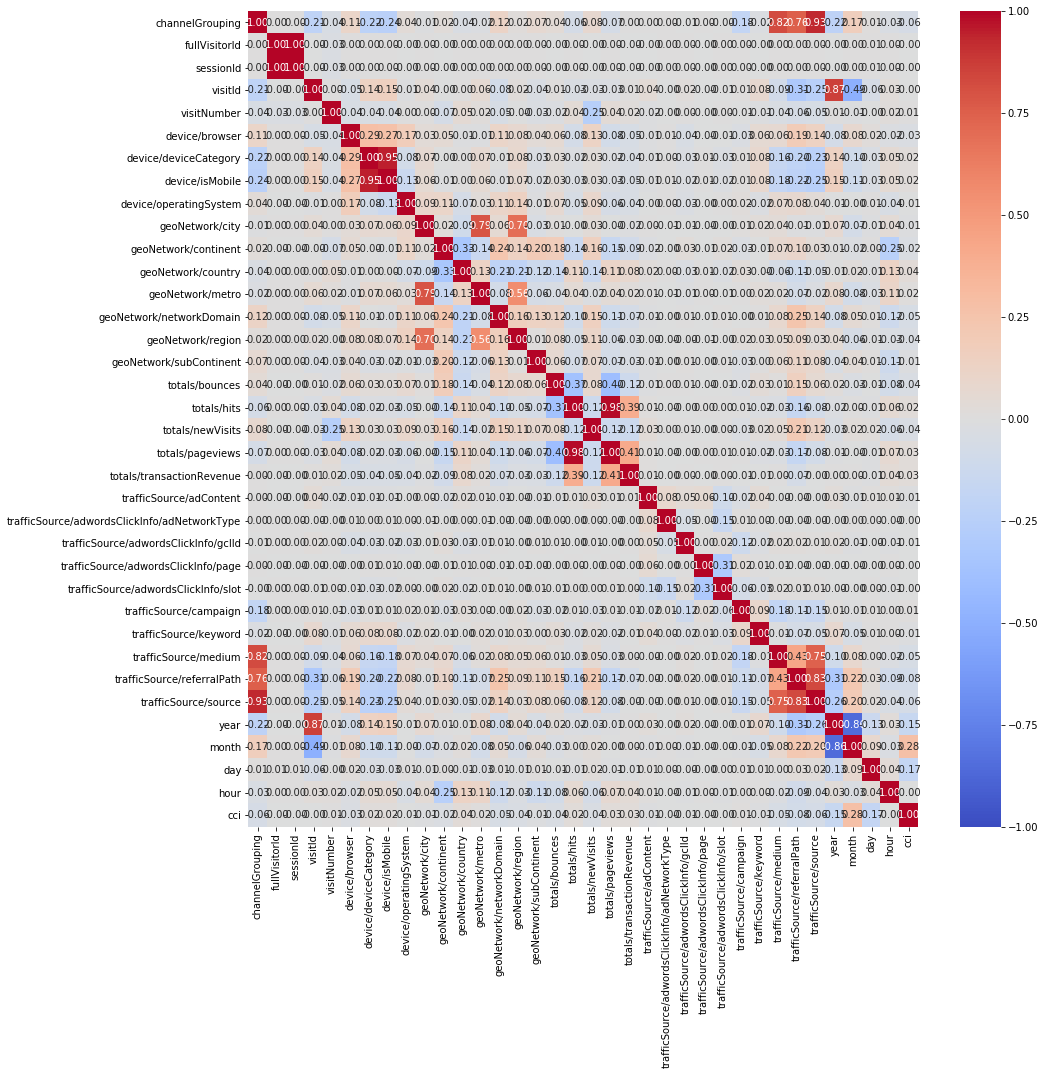

In [162]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

corr_matrix = train.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, vmin=-1, vmax=1, 
            cbar_kws=dict(ticks=list(np.arange(-1.0, 1.1, 0.25))), fmt='.2f')
plt.show()

---
# Train models

In [133]:
def get_tt_split(df):
    X = df.drop(columns=['totals/transactionRevenue'])
    y = df['totals/transactionRevenue']
    
    return train_test_split(X, y, test_size = 0.2, random_state = 3)

### Linear Regression

In [134]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def train_lr(df):
    X_train, X_test, y_train, y_test = get_tt_split(df)
    
    model = LinearRegression()
    print('Training model: {0}...\n'.format('lr'))
    model.fit(X_train, y_train)
    test_predictions = model.predict(X_test)
    
    mse = mean_squared_error(y_test, test_predictions)
    rmse = sqrt(mse)
    
    print('=====')
    print('RMSE:', rmse)
    print('=====\n\n==========')
    print('INTERCEPT:', model.intercept_)
    print('==========\n\n==========================')
    print('COEFFICIENTS (decreasing):')
    print('==========================')
    coefficients = list(zip(X_test.columns, model.coef_))
    coefficients.sort(key = lambda c: c[1])
    for i in coefficients[::-1]:
        print('{0}:\n\t{1}\n'.format(i[0], i[1]))
    
    
    return model

In [135]:
lr_model = train_lr(train)

Training model: lr...

=====
RMSE: 1.8582042602885003
=====

INTERCEPT: -8945.188106692283

COEFFICIENTS (decreasing):
year:
	4.487084086070805

cci:
	0.9497436446335232

month:
	0.37933675230094605

totals/bounces:
	0.363238514656037

trafficSource/adwordsClickInfo/slot:
	0.2992764586748016

totals/pageviews:
	0.2849859575235485

channelGrouping:
	0.059747556269402216

day:
	0.011871894341614798

trafficSource/adContent:
	0.011693834182549922

device/deviceCategory:
	0.004408077716144586

trafficSource/source:
	0.003090068499541729

hour:
	0.001843874222378695

geoNetwork/subContinent:
	0.0013423081944144736

device/browser:
	0.0010867602069682433

geoNetwork/country:
	0.0009216301740737308

geoNetwork/region:
	0.0007069049252243412

fullVisitorId:
	0.00012093080782167554

trafficSource/adwordsClickInfo/gclId:
	1.3157031178684452e-05

trafficSource/adwordsClickInfo/adNetworkType:
	-2.9740515605780615e-12

visitId:
	-1.3634377836152002e-07

geoNetwork/networkDomain:
	-2.905028394798038

In [137]:
import xgboost as xgb
from xgboost import DMatrix
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def train_xgb(df):
    X_train, X_test, y_train, y_test = get_tt_split(df)
    
    print('Training model: {0}...'.format('xgb'))
    model = xgb.train({}, DMatrix(X_train, y_train))
    test_predictions = model.predict(DMatrix(X_test))
    
    mse = mean_squared_error(y_test, test_predictions)
    rmse = sqrt(mse)
    
    print('=====')
    print('RMSE:', rmse)
    return model

In [138]:
xgb_model = train_xgb(train)

Training model: xgb...
=====
RMSE: 1.7147403852259484


---
# Specify model

In [ ]:
selected_model = 'lr'

In [ ]:
test

if selected_model == 'lr':
    model = train_lr(df)
elif selected_model == 'xgb':
    model = train_xgb(df)
    real_X = DMatrix(real_X)